This analysis techniques we will focuses **Time Series Analysis** and maybe we can mention about,
**Survival Analysis** or **Deep Learning** Techniques

## ***Brief description of the data set you chose, a summary of its attributes, and an outline of what you are trying to accomplish with this analysis.***

Dataset from [UCL](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset) 
**about the** Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in industry to the best of our knowledge.

# Attribute Information:

#### **The dataset consists of 10 000 data points stored as rows with 14 features in columns**

- **UID:** unique identifier ranging from 1 to 10000
- **product ID:** consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
- **air temperature [K]:** generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- **process temperature [K]:** generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- **rotational speed [rpm]:** calculated from a power of 2860 W, overlaid with a normally distributed noise
- **torque [Nm]:** torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.
- **tool wear [min]:** The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

## **The machine failure consists of five independent failure modes**
- **tool wear failure (TWF):** the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
- **heat dissipation failure (HDF):** heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.
- **power failure (PWF):** the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
- **overstrain failure (OSF):** if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
- **random failures (RNF):** each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail



## Import Dataset and Libraries ;  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
from lifelines import CoxPHFitter, KaplanMeierFitter

In [2]:
dF = pd.read_csv("ai4i2020.csv")

In [3]:
dF.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
EndTime = '2020-08-30' #Dataset denoted date 
dF['Date [H]'] = pd.date_range(end = EndTime, periods = 10000, freq = 'H')

In [5]:
dF.set_index('Date [H]', inplace = True)
dF.drop(['UDI', 'Product ID'], inplace = True, axis = 1)

In [6]:
dF.tail(10)
#Here we see last date end of august

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
Date [H],,,,,,,,,,,,
2020-08-29 15:00:00,L,298.8,308.5,1527,36.2,3,0,0,0,0,0,0
2020-08-29 16:00:00,M,298.9,308.4,1827,26.1,5,0,0,0,0,0,0
2020-08-29 17:00:00,L,298.8,308.4,1484,39.2,8,0,0,0,0,0,0
2020-08-29 18:00:00,L,298.8,308.4,1401,47.3,10,0,0,0,0,0,0
2020-08-29 19:00:00,L,298.8,308.3,1634,27.9,12,0,0,0,0,0,0
2020-08-29 20:00:00,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
2020-08-29 21:00:00,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
2020-08-29 22:00:00,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
2020-08-29 23:00:00,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


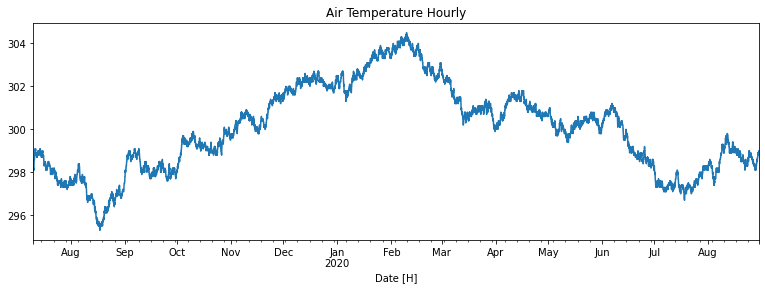

In [7]:
#Generally Air Temprature PLot. As a hourly

dF['Air temperature [K]'].plot(figsize = (13,4), title = 'Air Temperature Hourly')
plt.show()

In [8]:
#Five numerical type belong each summary statistics here if we want
# comment all variables summary statistics and we decide them tent normal or not normal 
# looking mean and median 
dF.iloc[:,1:6].describe().T

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0


In [9]:
Var = list(dF.columns)[0:6]
Var

['Type',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]']

In [10]:
dF['Type'].unique()

consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number

In [11]:
dF1 = dF[dF.Type == 'M'][Var]
dF2 = dF[dF.Type == 'L'][Var]
dF3 = dF[dF.Type == 'H'][Var]
dF1.rename(columns = {'Type':'Medium(30%)'}, inplace = True)
dF2.rename(columns  = {'Type':'Low(50%)'}, inplace = True)
dF3.rename(columns = {'Type':'High(20%)'}, inplace = True)

**We split downsampling each subset as  short seasonal**

In [12]:
Daily1 = dF1.resample('D').sum()
Weekly1 = dF1.resample('W').sum()
Monthly1 = dF1.resample('M').sum()
Quarterly1 = dF1.resample('Q').sum()
Yearly1 =  dF1.resample('Y').sum()

In [13]:
Daily2 = dF2.resample('D').sum()
Weekly2 = dF2.resample('W').sum()
Monthly2 = dF2.resample('M').sum()
Quarterly2 = dF2.resample('Q').sum()
Yearly2 =  dF2.resample('Y').sum()

In [14]:
Daily3 = dF3.resample('D').sum()
Weekly3 = dF3.resample('W').sum()
Monthly3 = dF3.resample('M').sum()
Quarterly3 = dF3.resample('Q').sum()
Yearly3 =  dF3.resample('Y').sum()

# Plotting Each Type Product Level

In [15]:
plotsize = (12,4)

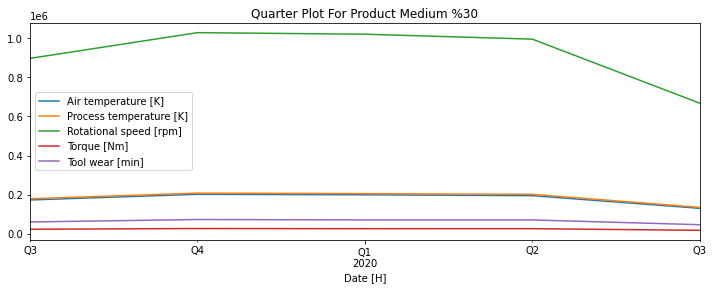

In [16]:
Quarterly1.plot(figsize = plotsize, title  = 'Quarter Plot For Product Medium %30')
plt.show()




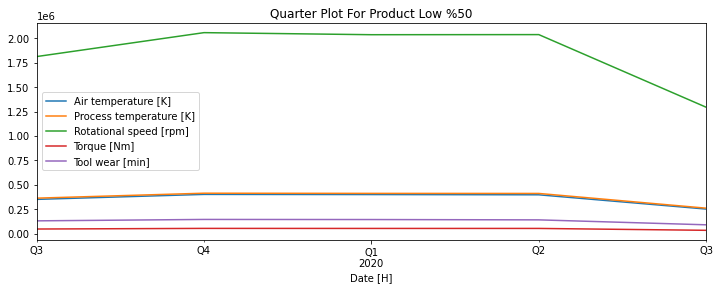

In [17]:
Quarterly2.plot(figsize = plotsize, title  = 'Quarter Plot For Product Low %50')
plt.show()

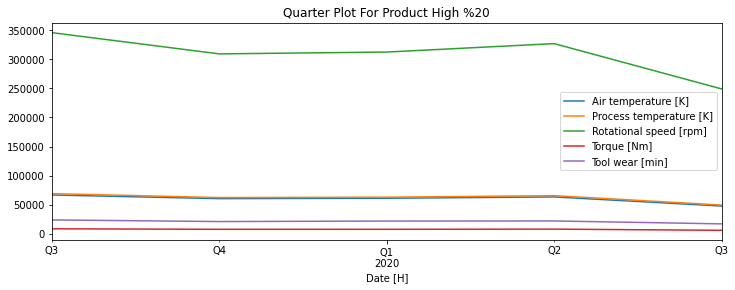

In [18]:
Quarterly3.plot(figsize = plotsize, title  = 'Quarter Plot For Product High %20')
plt.show()

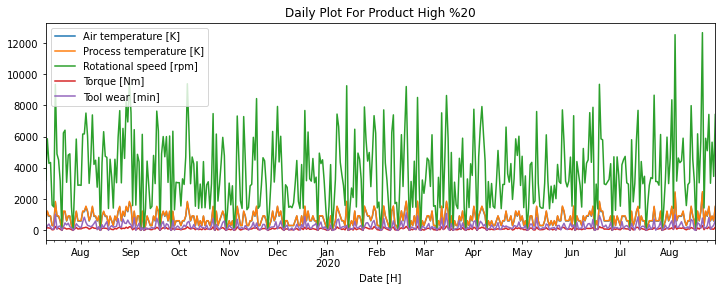

In [19]:
Daily3.plot(figsize = plotsize, title  = 'Daily Plot For Product High %20')
plt.show()

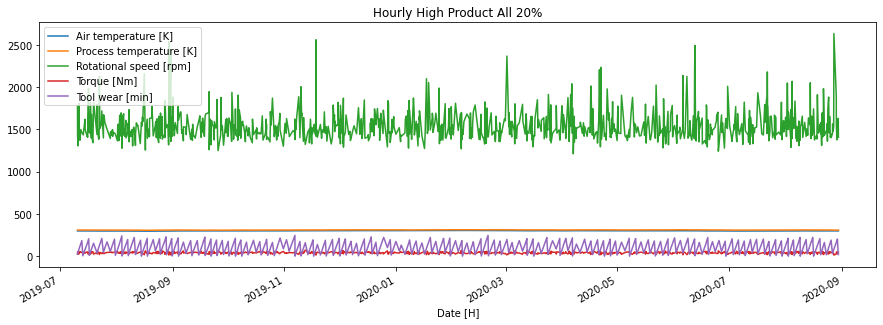

In [20]:
dF3.plot(figsize = (15,5), title = 'Hourly High Product All 20%')
plt.show()

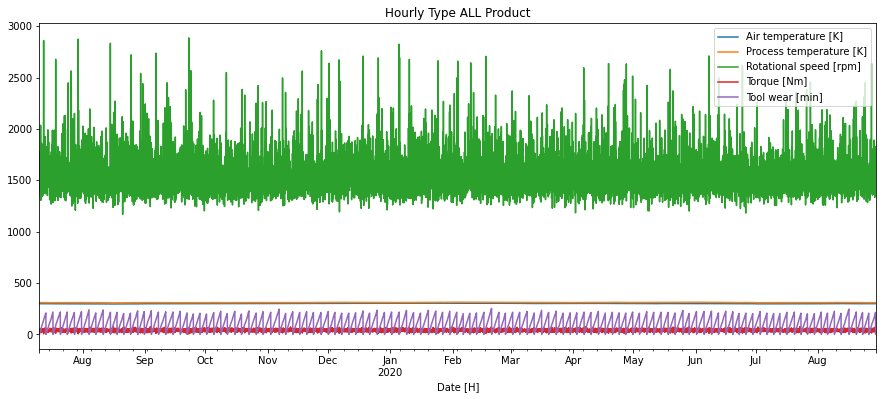

In [21]:
dF[Var].plot(figsize = (15,6), title = 'Hourly Type ALL Product')
plt.show()

**Above plot except Tool Wear min and Torque seem like a trend** But **Rotational Speed** 
seems strong time series so we take it and doing some time series analysis and decide seasonality trend or type multiplicative or additive 

# One Variable Time Series Analysis 

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
import time

In [23]:
dFTs = dF.loc[:,['Rotational speed [rpm]', 'Type', 'Tool wear [min]']]
dFTs['Tool wear [min]'] = pd.to_datetime(dFTs['Tool wear [min]'], unit='m')

In [24]:
dFTs.dtypes

In [25]:
dFTs_min = dFTs.set_index('Tool wear [min]')
dFTs_min.index.minute

Int64Index([ 0,  3,  5,  7,  9, 11, 14, 16, 18, 21,
            ...
             3,  5,  8, 10, 12, 14, 17, 22, 25, 30],
           dtype='int64', name='Tool wear [min]', length=10000)

In [26]:
pd.Series(dFTs_min.index.minute).unique()

## Here We Going To TS analyze

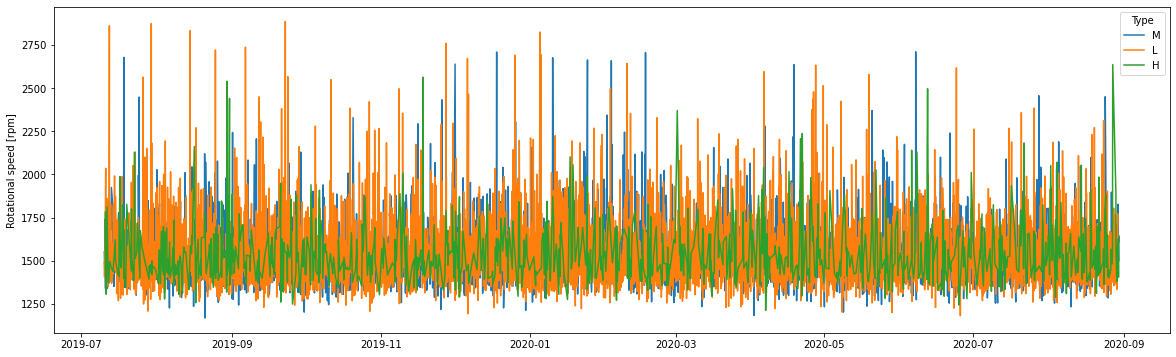

In [27]:
plt.figure(figsize = (20,6))
sns.lineplot(data = dFTs , x = dFTs.index.values,y = 'Rotational speed [rpm]', hue = 'Type' )
plt.show()

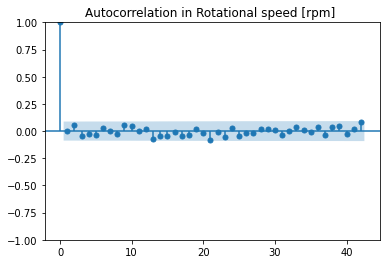

In [28]:
SupSample = dFTs.sample(n = 500, replace = False)
SubSampleAcf = plot_acf(SupSample['Rotational speed [rpm]'], lags=42,  title = 'Autocorrelation in Rotational speed [rpm] ')

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


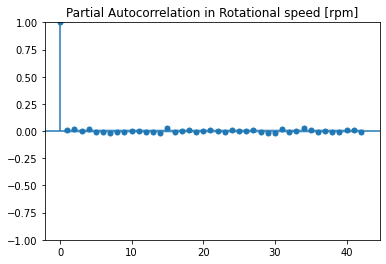

In [29]:
acf_plot = plot_acf(dFTs['Rotational speed [rpm]'], lags=42,  title = 'Autocorrelation in Rotational speed [rpm] ')
pacf_plot = plot_pacf(dFTs['Rotational speed [rpm]'], lags = 42, title = 'Partial Autocorrelation in Rotational speed [rpm]')

when we look at the **ACF** and **PACF** plot time series seem like  stationary 

In [30]:
from statsmodels.tsa.stattools import adfuller
adf, p_value, usedlags, nobs, critical_values, icbest = adfuller(dFTs['Rotational speed [rpm]'])

In [31]:
print(f'ADF:{adf:.2f}')

ADF:-69.11


First, adf is the value of the test statistic. The more negative the value, the more confident we can be that the series is stationary. Here we see a value of -10. That may not mean anything to you just yet but the pvalue should.


- **H0: Series Non-Stationary**
- **H1: Series Stationary**

In [32]:
print(f'P-Value : {p_value}') 

P-Value : 0.0


Null hypothesis reject series stationary:

**Ask Na if we do na we can fill it using interpolate techniques**

In [33]:
for colnames in dF.columns:
    print(f'{colnames}: have {sum(dF[colnames].isna())} missing value')

Type: have 0 missing value
Air temperature [K]: have 0 missing value
Process temperature [K]: have 0 missing value
Rotational speed [rpm]: have 0 missing value
Torque [Nm]: have 0 missing value
Tool wear [min]: have 0 missing value
Machine failure: have 0 missing value
TWF: have 0 missing value
HDF: have 0 missing value
PWF: have 0 missing value
OSF: have 0 missing value
RNF: have 0 missing value


lastly here;  **TWF** **HDF** **PWF** **OSF** **RNF** and **MACHİNE FAİLURE** logical variables so I meant they categorical

## **The machine failure consists of five independent failure modes**
- **tool wear failure (TWF):** the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
- **heat dissipation failure (HDF):** heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.
- **power failure (PWF):** the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
- **overstrain failure (OSF):** if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
- **random failures (RNF):** each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail

**Later we will use these variables Survival Analysis Machine failure and target value Cox Regression**
**We will take event col as Tool Wear min**

In [34]:
Categorical = list(dF.columns)[6:]
Categorical

['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

In [35]:
for cat in Categorical:
    print(f'\nUnique Values Each Categorical Variable\n{cat} Unique Values\n{dF[cat].unique()}')


Unique Values Each Categorical Variable
Machine failure Unique Values
[0 1]

Unique Values Each Categorical Variable
TWF Unique Values
[0 1]

Unique Values Each Categorical Variable
HDF Unique Values
[0 1]

Unique Values Each Categorical Variable
PWF Unique Values
[0 1]

Unique Values Each Categorical Variable
OSF Unique Values
[0 1]

Unique Values Each Categorical Variable
RNF Unique Values
[0 1]


we can set,  
- **0:** failure,
- **1:** not failure,
for Survival Analysis

In [36]:
dF[Categorical]

,Machine failure,TWF,HDF,PWF,OSF,RNF
Date [H],,,,,,
2019-07-10 09:00:00,0,0,0,0,0,0
2019-07-10 10:00:00,0,0,0,0,0,0
2019-07-10 11:00:00,0,0,0,0,0,0
2019-07-10 12:00:00,0,0,0,0,0,0
2019-07-10 13:00:00,0,0,0,0,0,0
...,...,...,...,...,...,...
2020-08-29 20:00:00,0,0,0,0,0,0
2020-08-29 21:00:00,0,0,0,0,0,0
2020-08-29 22:00:00,0,0,0,0,0,0


dF['Machine failure'][dF['Machine failure'] == 1] = 'Not Failure'
dF['Machine failure'][dF['Machine failure'] == 0] = 'Failure'

for col in Categorical[1:]:
    dF[col][dF[col]==1] = 'Not Failure'
    dF[col][dF[col]==0] = 'Failure'

for cat in Categorical:
    print(f'\nUnique Values Each Categorical Variable\n{cat} Unique Values\n{dF[cat].unique()}')

In [37]:
dF[Categorical]

,Machine failure,TWF,HDF,PWF,OSF,RNF
Date [H],,,,,,
2019-07-10 09:00:00,0,0,0,0,0,0
2019-07-10 10:00:00,0,0,0,0,0,0
2019-07-10 11:00:00,0,0,0,0,0,0
2019-07-10 12:00:00,0,0,0,0,0,0
2019-07-10 13:00:00,0,0,0,0,0,0
...,...,...,...,...,...,...
2020-08-29 20:00:00,0,0,0,0,0,0
2020-08-29 21:00:00,0,0,0,0,0,0
2020-08-29 22:00:00,0,0,0,0,0,0


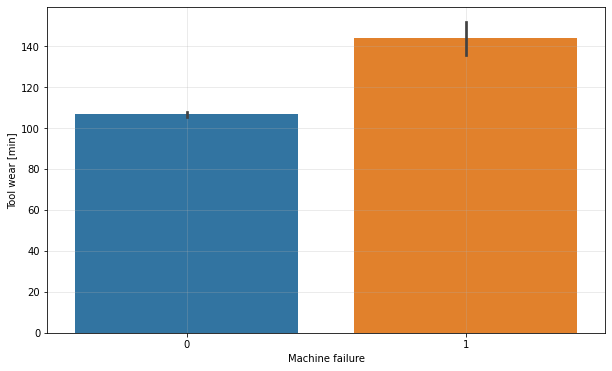

In [38]:
plt.figure(figsize=(10,6))
sns.barplot(data = dF,
            x = 'Machine failure',
            y = 'Tool wear [min]')
plt.grid(alpha = .3)
plt.show()

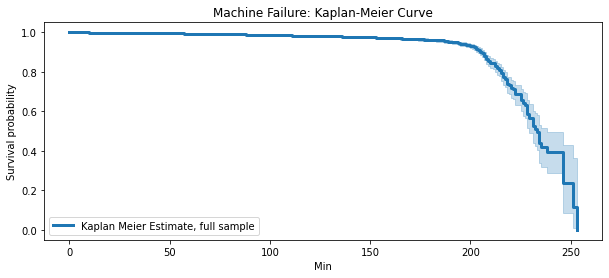

In [39]:
kmf = KaplanMeierFitter()
kmf.fit(dF['Tool wear [min]'], dF['Machine failure'], label = 'Kaplan Meier Estimate, full sample')
kmf.plot(linewidth = 3, figsize = (10,4))
plt.title('Machine Failure: Kaplan-Meier Curve')
plt.xlabel('Min')
plt.ylabel('Survival probability')
plt.show()

In [40]:
Categorical

['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

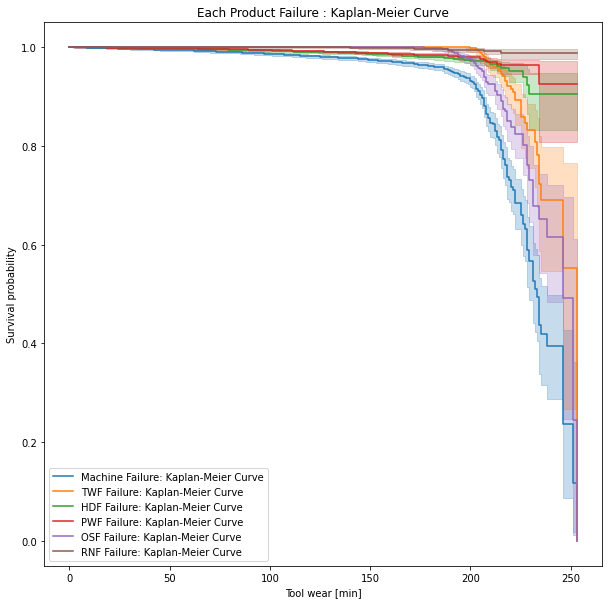

In [41]:

kmf.fit(dF['Tool wear [min]'], dF['Machine failure'])
kmf.plot(label = "Machine Failure: Kaplan-Meier Curve", figsize = (10, 10))

kmf.fit(dF['Tool wear [min]'], dF['TWF'])
kmf.plot(label='TWF Failure: Kaplan-Meier Curve')

kmf.fit(dF['Tool wear [min]'], dF['HDF'])
kmf.plot(label='HDF Failure: Kaplan-Meier Curve')

kmf.fit(dF['Tool wear [min]'], dF['PWF'])
kmf.plot(label='PWF Failure: Kaplan-Meier Curve')

kmf.fit(dF['Tool wear [min]'], dF['OSF'])
kmf.plot(label='OSF Failure: Kaplan-Meier Curve')

kmf.fit(dF['Tool wear [min]'], dF['RNF'])
kmf.plot(label='RNF Failure: Kaplan-Meier Curve')


plt.title('Each Product Failure : Kaplan-Meier Curve')
plt.xlabel('Tool wear [min]')
plt.ylabel('Survival probability')
plt.show()

The most strongly failure time has RNF then later  PWF most weakness failure so ı meant has a less survival rate machine failure in specific times

# **Cox** Regression 

In [42]:
import warnings
warnings.simplefilter(action='ignore')

In [43]:
dFC = dF[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF','Tool wear [min]']]
dFC.reset_index(inplace=True)
dFC.drop('Date [H]',inplace=True,axis=1)
dFC

,Machine failure,TWF,HDF,PWF,OSF,RNF,Tool wear [min]
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,3
2,0,0,0,0,0,0,5
3,0,0,0,0,0,0,7
4,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,14
9996,0,0,0,0,0,0,17
9997,0,0,0,0,0,0,22
9998,0,0,0,0,0,0,25


In [47]:
cph1 = CoxPHFitter()
cph1.fit(dFC, duration_col = 'Tool wear [min]', event_col = 'HDF')
cph1.print_summary(style = 'ascii')

<lifelines.CoxPHFitter: fitted with 10000 total observations, 9885 right-censored observations>
             duration col = 'Tool wear [min]'
                event col = 'HDF'
      baseline estimation = breslow
   number of observations = 10000
number of events observed = 115
   partial log-likelihood = -454.19
         time fit was run = 2021-11-01 19:57:20 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
Machine failure  24.51   4.40e+10    2016.32         -3927.41          3976.43                 0.00                  inf
TWF             -24.22       0.00    9436.86        -18520.13         18471.69                 0.00                  inf
PWF              -2.98       0.05       0.59            -4.13            -1.83                 0.02                 0.16
OSF              -4.59  

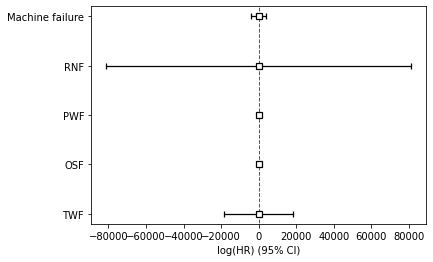

In [48]:
cph1.plot()
plt.show()

here confidence interval involve 0 that meants as statistically not significant 